In [9]:
import numpy as np

# Parameters
n_iterations = 100
n_device_options = [50, 100, 150, 200, 250, 300]
n_mecs = 10
mec_capacity = 4
transmission_power = 0.5
mec_voltage = 1.0
device_voltage = 1.0
task_data = np.array([5, 10, 15, 20, 25, 30, 35, 40, 45])
transmission_rate = np.array([500, 1000, 1500, 2000, 2500, 3000]) * 1e-3
energy_unit = 100
time_unit = 1000
# Break down objective calculations
def energy_consumption(position, interference_factor=1.0):
    # The interference_factor can be a value obtained from real-world measurements
    per_device_energy = interference_factor * transmission_power * device_voltage * np.sum(task_data * position)
    return per_device_energy

def completion_time(position, device_transmission_rates):
    epsilon = 1e-10
    position = np.clip(position, epsilon, 1)  # this ensures no value goes below epsilon
    
    return np.sum(task_data / (device_transmission_rates * position))


def mec_energy(tasks):
    mec_energy_per_task = mec_voltage * 0.1 
    return np.sum(tasks) * mec_energy_per_task


def objective_function(position, weight_energy=0.5, weight_time=0.5):
    device_transmission_rates = np.random.choice(transmission_rate, len(task_data))
    return weight_energy * energy_consumption(position) + weight_time * completion_time(position, device_transmission_rates)

class QPSO:
    def __init__(self, dim, n_particles, iterations):
        self.dim = dim
        self.n_particles = n_particles
        self.iterations = iterations
        
        # Initialize positions and velocities
        self.positions = np.random.uniform(0, 1, (n_particles, dim))
        self.velocities = np.random.uniform(-0.1, 0.1, (n_particles, dim))

        # Initialize pbest and gbest
        self.pbest_positions = self.positions.copy()
        self.pbest_values = np.array([float('inf')] * n_particles)
        self.gbest_position = np.random.uniform(0, 1, dim)
        self.gbest_value = float('inf')
        
        # Constants for QPSO, you can adjust these or initialize them externally
        self.alpha = 0.5  # inertia
        self.beta = 1.5  # personal attraction
        self.gamma = 1.5  # global attraction


        
    def update(self):
        for i in range(self.n_particles):
            # Update velocity
            self.velocities[i] = (self.alpha * self.velocities[i] + 
                                self.beta * np.random.uniform(0, 1, self.dim) * (self.pbest_positions[i] - self.positions[i]) +
                                self.gamma * np.random.uniform(0, 1, self.dim) * (self.gbest_position - self.positions[i]))

            # Update position
            self.positions[i] += self.velocities[i]

            # Make sure position values are between 0 and a defined upper boundary (e.g., 1)
            self.positions[i] = np.clip(self.positions[i], 0, 1)

            # Make sure position values are non-negative
            self.positions[i] = np.maximum(self.positions[i], 0)
           
            
            # Update pbest
            current_value = objective_function(self.positions[i])
            if current_value < self.pbest_values[i]:
                self.pbest_positions[i] = self.positions[i].copy()
                self.pbest_values[i] = current_value
                # Update gbest
                if current_value < self.gbest_value:
                    self.gbest_position = self.positions[i].copy()
                    self.gbest_value = current_value
  
    def optimize(self):
        for _ in range(self.iterations):
            self.update()
            
        return self.gbest_value, self.gbest_position


# Instantiate and run QPSO for each device setting
results = {}

for n_device in n_device_options:
    qpso = QPSO(dim=len(task_data), n_particles=n_device, iterations=n_iterations)
    best_value, best_position = qpso.optimize()
    mean_energy = energy_consumption(best_position)
    mean_time = completion_time(best_position, device_transmission_rates)
    results[n_device] = (best_value, best_position, mean_energy, mean_time)

for n_device, (value, position, energy, time) in results.items():
    print(f"For {n_device} devices -> Best value: {value}")
    print(f"Mean Energy Consumption: {energy * n_device / energy_unit}")
    print(f"Mean Task Completion Time: {time * n_device / time_unit}\n")


For 50 devices -> Best value: 99.60366598059102
Mean Energy Consumption: 47.55776493488091
Mean Task Completion Time: 15.569922576458914

For 100 devices -> Best value: 101.24043088556425
Mean Energy Consumption: 85.06472143072432
Mean Task Completion Time: 31.249560123252394

For 150 devices -> Best value: 98.71179653316989
Mean Energy Consumption: 136.05227797842966
Mean Task Completion Time: 42.40423704081447

For 200 devices -> Best value: 96.83395219717707
Mean Energy Consumption: 191.2452546102456
Mean Task Completion Time: 56.272835983875936

For 250 devices -> Best value: 100.06571328938315
Mean Energy Consumption: 206.886715093575
Mean Task Completion Time: 80.32183577939281

For 300 devices -> Best value: 97.38385303315391
Mean Energy Consumption: 283.48220231157234
Mean Task Completion Time: 93.90682392944672



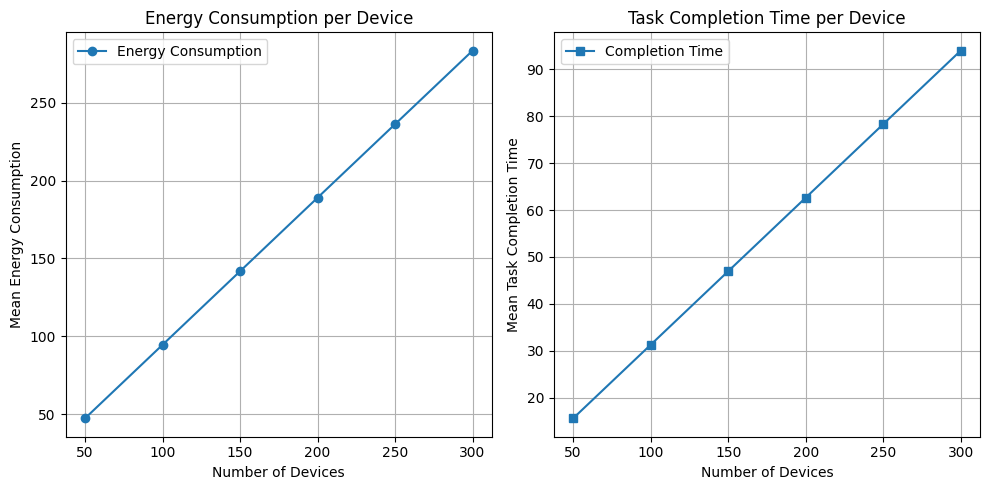

In [13]:
import matplotlib.pyplot as plt

devices = []
energies = []
completion_times = []

for n_device in n_device_options:

    devices.append(n_device)
    energies.append(energy * n_device / energy_unit)
    completion_times.append(time * n_device / time_unit)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # First subplot for energy consumption
plt.plot(devices, energies, 'o-', label='Energy Consumption')
plt.xlabel('Number of Devices')
plt.ylabel('Mean Energy Consumption')
plt.title('Energy Consumption per Device')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)  # Second subplot for completion time
plt.plot(devices, completion_times, 's-', label='Completion Time')
plt.xlabel('Number of Devices')
plt.ylabel('Mean Task Completion Time')
plt.title('Task Completion Time per Device')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

